In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np
import missingno

from IPython.display import display
from woodwork.column_schema import ColumnSchema
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, fbeta_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import BinaryEncoder

import featuretools as ft
from featuretools.primitives import TransformPrimitive
from featuretools.primitives import numeric

In [2]:
timestep = 17 #from 1 to 23 (17 with the current NaN strategy)
threshold_for_classification = -30
fill_X = -0.25
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
seed = 11
features = ['event_id', 'time_to_tca', 'risk', 
            'c_time_lastob_end', 'c_time_lastob_start',
            'max_risk_estimate', 'c_ctdot_r', 'c_obs_used',
            'miss_distance', 'c_obs_available', 'c_recommended_od_span',
            'c_object_type_PAYLOAD', 'c_object_type_UNKNOWN',
            'c_actual_od_span', 'c_cr_area_over_mass', 't_h_per',
            'relative_velocity_t', 'relative_speed', 't_rcs_estimate',
            'c_cd_area_over_mass', 'c_crdot_t', 'c_sigma_t', 'c_sigma_rdot',
            'max_risk_scaling', 't_span']

In [3]:
df = pd.read_csv("train_data.csv")

def wrangling(df):
    #Dropping first the empty column and then rows with NaNs
    df = df.drop("c_rcs_estimate", axis=1)
    df = df.dropna(how='any')

    #Filtering events with len=1 or min_tca > 2 or max_tca < 2
    def conditions(event):
        x = event["time_to_tca"].values
        return ((x.min()<2.0) & (x.max()>2.0))
    df = df.groupby('event_id').filter(conditions)

    #OHE for c_object_type (5 categories) -> 5 new features
    df["mission_id"] = df["mission_id"].astype('category')
    df["c_object_type"] = df["c_object_type"].astype('category')
    df = pd.get_dummies(df)

    #Getting X as df (dropping rows with tca < 2) 
    df = df.loc[df["time_to_tca"]>2]

    # Selecting features from feature selection
    df = df[features]

    ### Feature Engineering ###

    #Adding feature 'event_length' for counting how many instances each event has
    df["event_length"] = df.groupby('event_id')['event_id'].transform('count')
    
    #Adding feature 'high_risk_count' for counting how many high risk instances each event has
    df["high_risk_count"] = df.groupby('event_id')['risk'].transform(lambda x: (x > -6.0).sum())
    
    #Adding feature 'mean_tca_jump' for computing mean tca jump each event has
    df["mean_tca_jump"] = df.groupby('event_id')['time_to_tca'].transform(lambda x: x.diff().mean())
    
    #Adding feature 'mean_risk_jump' for computing mean risk jump each event has
    df["mean_risk_jump"] = df.groupby('event_id')['risk'].transform(lambda x: x.diff().mean())
    
    #Adding feature 'positive_risk_jump' for computing positive risk jumps each event has (from high to low)
    df["positive_risk_jump"] = df.groupby('event_id')['risk'].transform(lambda x: (x.diff() > 0.0).sum())
    
    #Adding feature 'negative_risk_jump' for computing positive risk jumps each event has (from low to high)
    df["negative_risk_jump"] = df.groupby('event_id')['risk'].transform(lambda x: (x.diff() < 0.0).sum())
    
    #Fill NaNs 
    values = {'mean_tca_jump': 0, 'mean_risk_jump': 0}
    df.fillna(value=values, inplace=True)
    
    return df
    
df = wrangling(df)
df

,event_id,time_to_tca,risk,c_time_lastob_end,c_time_lastob_start,max_risk_estimate,c_ctdot_r,c_obs_used,miss_distance,c_obs_available,c_recommended_od_span,c_object_type_PAYLOAD,c_object_type_UNKNOWN,c_actual_od_span,c_cr_area_over_mass,t_h_per,relative_velocity_t,relative_speed,t_rcs_estimate,c_cd_area_over_mass,c_crdot_t,c_sigma_t,c_sigma_rdot,max_risk_scaling,t_span,event_length,high_risk_count,mean_tca_jump,mean_risk_jump,positive_risk_jump,negative_risk_jump
9,2,6.983474,-10.816161,2.0,180.0,-6.601713,-0.996314,15.0,22902.0,15.0,13.87,0,1,13.87,0.564380,774.097978,-13792.0,14348.0,3.4505,0.814291,-0.999989,38173.433170,39.695541,13.293159,12.0,14,0,-0.357142,-1.475680,0,2
10,2,6.691611,-10.850473,2.0,180.0,-6.603452,-0.996313,15.0,22966.0,15.0,13.87,0,1,13.87,0.564380,774.094612,-13792.0,14348.0,3.4505,0.814291,-0.999989,38098.346421,39.617319,13.374242,12.0,14,0,-0.357142,-1.475680,0,2
11,2,6.269979,-30.000000,0.0,1.0,-6.217958,-0.999774,15.0,18785.0,15.0,14.63,0,1,14.63,0.476139,774.102169,-13791.4,14347.0,3.4505,0.849987,-0.999602,2521.604251,2.616749,426.808532,12.0,14,0,-0.357142,-1.475680,0,2
12,2,6.042352,-30.000000,0.0,1.0,-6.271078,-0.999656,15.0,18842.0,15.0,14.63,0,1,14.63,0.476139,774.101759,-13791.4,14347.0,3.4479,0.849987,-0.999944,6720.228419,6.985796,181.496778,12.0,14,0,-0.357142,-1.475680,0,2
13,2,5.711716,-30.000000,0.0,1.0,-6.277448,-0.999649,15.0,19015.0,15.0,14.63,0,1,14.63,0.476139,774.095498,-13791.4,14347.0,3.4479,0.849987,-0.999942,6617.418681,6.878515,187.525360,12.0,14,0,-0.357142,-1.475680,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162628,13153,3.408859,-7.080451,2.0,180.0,-5.140501,-0.661773,15.0,2205.0,17.0,28.89,0,1,28.89,0.271941,674.656210,-14937.0,14976.0,4.8957,1.001898,-0.999999,46108.589222,48.666693,7.492353,21.0,12,0,-0.437633,0.003148,6,5
162629,13153,3.029751,-7.108630,2.0,180.0,-5.142668,-0.664416,15.0,2307.0,17.0,28.89,0,1,28.89,0.271941,674.657217,-14937.0,14976.0,4.8957,1.001898,-0.999999,45931.949665,48.480202,7.561579,21.0,12,0,-0.437633,0.003148,6,5
162630,13153,2.799253,-7.070070,2.0,180.0,-5.137869,-0.663148,15.0,2254.0,17.0,28.89,0,1,28.89,0.271941,674.660168,-14937.0,14976.0,4.8957,1.001898,-0.999999,46012.313569,48.565132,7.471857,21.0,12,0,-0.437633,0.003148,6,5
162631,13153,2.385399,-7.066209,2.0,180.0,-5.137034,-0.663521,15.0,2259.0,17.0,28.89,0,1,28.89,0.271941,674.660170,-14937.0,14976.0,4.8957,1.001898,-0.999999,45995.488909,48.547317,7.463470,21.0,12,0,-0.437633,0.003148,6,5


In [4]:
feature_for_ft = ['time_to_tca', 'risk', 'c_time_lastob_end', 
                 'c_time_lastob_start', 'max_risk_estimate',
                 'max_risk_scaling', "event_length",
                 "high_risk_count", "mean_tca_jump",
                 "mean_risk_jump", "positive_risk_jump"]

df_ = df[feature_for_ft]
def feature_tools(df):
    
    # Make an entityset and add the entity
    es = ft.EntitySet(id = 'events')
    es.add_dataframe(dataframe_name=  'data', dataframe = df, 
                             make_index = True, index = 'index')
    
    #Trans Primitives
    class Log(TransformPrimitive):
        name = 'Log'
        input_types = [ColumnSchema(semantic_tags={"numeric"})]
        return_type = ColumnSchema(semantic_tags={"numeric"})

        def get_function(self):
            def Log(column):
                return np.log(column)
            return Log
    class Square_Root(TransformPrimitive):
        name = 'Square_Root'
        input_types = [ColumnSchema(semantic_tags={"numeric"})]
        return_type = ColumnSchema(semantic_tags={"numeric"})

        def get_function(self):
            def Square_Root(column):
                return np.sqrt(column)
            return Square_Root
    
    # Run deep feature synthesis with transformation primitives
    feature_matrix, feature_defs = ft.dfs(entityset = es,
                                          target_dataframe_name = 'data',
                                          trans_primitives = ['add_numeric',
                                                              'multiply_numeric',
                                                              'subtract_numeric',
                                                              'divide_numeric',
                                                              'modulo_numeric',
                                                              Log,
                                                              Square_Root
                                                             ],
                                            max_features=1000,
                                            max_depth=2,
                                            n_jobs=1)

    return feature_matrix, feature_defs

feature_matrix, feature_defs = feature_tools(df_)

feature_matrix.head()

C:\Users\karan\AppData\Roaming\Python\Python310\site-packages\featuretools\synthesis\deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(
C:\Users\karan\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\karan\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\karan\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,time_to_tca,risk,c_time_lastob_end,c_time_lastob_start,max_risk_estimate,max_risk_scaling,event_length,high_risk_count,mean_tca_jump,mean_risk_jump,positive_risk_jump,LOG(c_time_lastob_end),LOG(c_time_lastob_start),LOG(event_length),LOG(high_risk_count),LOG(max_risk_estimate),LOG(max_risk_scaling),LOG(mean_risk_jump),LOG(mean_tca_jump),LOG(positive_risk_jump),LOG(risk),LOG(time_to_tca),SQUARE_ROOT(c_time_lastob_end),SQUARE_ROOT(c_time_lastob_start),SQUARE_ROOT(event_length),SQUARE_ROOT(high_risk_count),SQUARE_ROOT(max_risk_estimate),SQUARE_ROOT(max_risk_scaling),SQUARE_ROOT(mean_risk_jump),SQUARE_ROOT(mean_tca_jump),SQUARE_ROOT(positive_risk_jump),SQUARE_ROOT(risk),SQUARE_ROOT(time_to_tca),c_time_lastob_end + c_time_lastob_start,c_time_lastob_end + event_length,c_time_lastob_end + high_risk_count,c_time_lastob_end + max_risk_estimate,c_time_lastob_end + max_risk_scaling,c_time_lastob_end + mean_risk_jump,c_time_lastob_end + mean_tca_jump,c_time_lastob_end + positive_risk_jump,c_time_lastob_end + risk,c_time_lastob_end + time_to_tca,c_time_lastob_start + event_length,c_time_lastob_start + high_risk_count,c_time_lastob_start + max_risk_estimate,c_time_lastob_start + max_risk_scaling,c_time_lastob_start + mean_risk_jump,c_time_lastob_start + mean_tca_jump,c_time_lastob_start + positive_risk_jump,c_time_lastob_start + risk,c_time_lastob_start + time_to_tca,event_length + high_risk_count,event_length + max_risk_estimate,event_length + max_risk_scaling,event_length + mean_risk_jump,event_length + mean_tca_jump,event_length + positive_risk_jump,event_length + risk,event_length + time_to_tca,high_risk_count + max_risk_estimate,high_risk_count + max_risk_scaling,high_risk_count + mean_risk_jump,high_risk_count + mean_tca_jump,high_risk_count + positive_risk_jump,high_risk_count + risk,high_risk_count + time_to_tca,max_risk_estimate + max_risk_scaling,max_risk_estimate + mean_risk_jump,max_risk_estimate + mean_tca_jump,max_risk_estimate + positive_risk_jump,max_risk_estimate + risk,max_risk_estimate + time_to_tca,max_risk_scaling + mean_risk_jump,max_risk_scaling + mean_tca_jump,max_risk_scaling + positive_risk_jump,max_risk_scaling + risk,max_risk_scaling + time_to_tca,mean_risk_jump + mean_tca_jump,mean_risk_jump + positive_risk_jump,mean_risk_jump + risk,mean_risk_jump + time_to_tca,mean_tca_jump + positive_risk_jump,mean_tca_jump + risk,mean_tca_jump + time_to_tca,positive_risk_jump + risk,positive_risk_jump + time_to_tca,risk + time_to_tca,c_time_lastob_end / c_time_lastob_start,c_time_lastob_end / event_length,c_time_lastob_end / high_risk_count,c_time_lastob_end / max_risk_estimate,c_time_lastob_end / max_risk_scaling,c_time_lastob_end / mean_risk_jump,c_time_lastob_end / mean_tca_jump,c_time_lastob_end / positive_risk_jump,c_time_lastob_end / risk,c_time_lastob_end / time_to_tca,c_time_lastob_start / c_time_lastob_end,c_time_lastob_start / event_length,c_time_lastob_start / high_risk_count,c_time_lastob_start / max_risk_estimate,c_time_lastob_start / max_risk_scaling,c_time_lastob_start / mean_risk_jump,c_time_lastob_start / mean_tca_jump,c_time_lastob_start / positive_risk_jump,c_time_lastob_start / risk,c_time_lastob_start / time_to_tca,event_length / c_time_lastob_end,event_length / c_time_lastob_start,event_length / high_risk_count,event_length / max_risk_estimate,event_length / max_risk_scaling,event_length / mean_risk_jump,event_length / mean_tca_jump,event_length / positive_risk_jump,event_length / risk,event_length / time_to_tca,high_risk_count / c_time_lastob_end,high_risk_count / c_time_lastob_start,high_risk_count / event_length,high_risk_count / max_risk_estimate,high_risk_count / max_risk_scaling,high_risk_count / mean_risk_jump,high_risk_count / mean_tca_jump,high_risk_count / positive_risk_jump,high_risk_count / risk,high_risk_count / time_to_tca,max_risk_estimate / c_time_lastob_end,max_risk_estimate / c_time_lastob_start,max_risk_estimate / event_length,max_risk_estimate / high_risk_count,max_risk_estimate / ma

In [5]:
pr = ft.list_primitives()
primitives = pr[pr["name"].str.contains('numeric')]["name"]
primitives

76               modulo_numeric_scalar
91            multiply_numeric_boolean
105                   multiply_numeric
114                        add_numeric
115                     modulo_numeric
123                     divide_numeric
132              divide_numeric_scalar
134                        numeric_lag
139                   subtract_numeric
142    scalar_subtract_numeric_feature
158            subtract_numeric_scalar
160                 add_numeric_scalar
179            multiply_numeric_scalar
Name: name, dtype: object

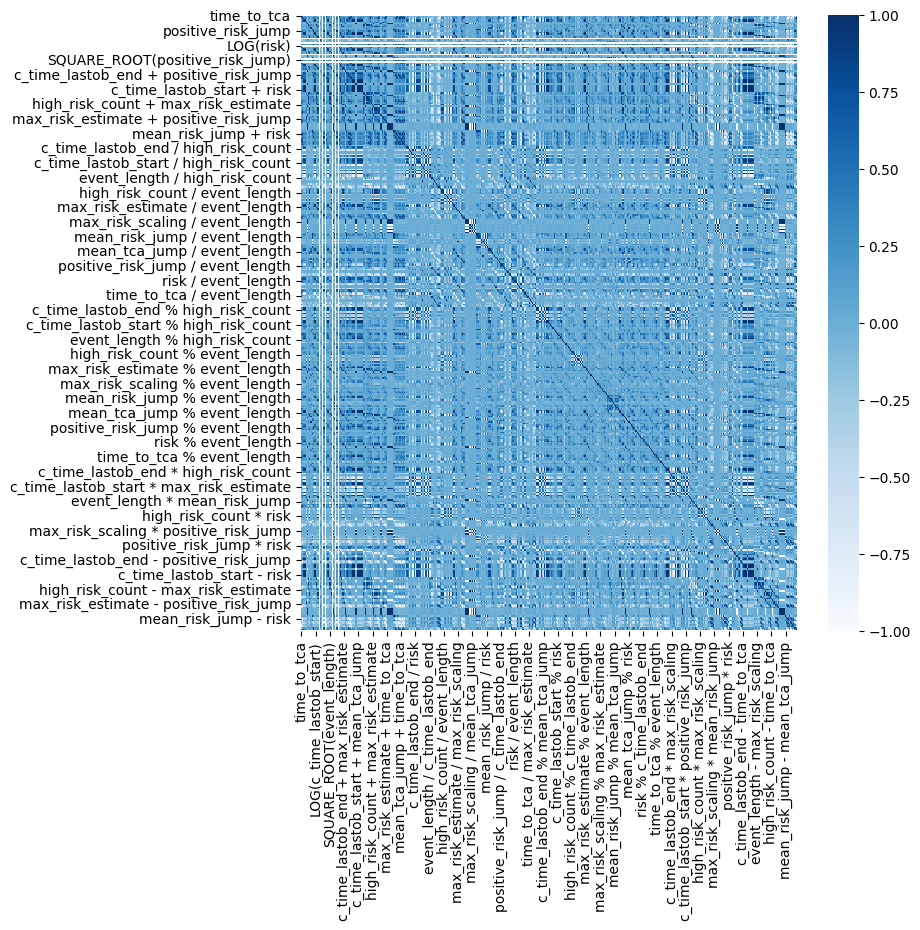

In [6]:
plt.figure(figsize=(8,8))
hm = sns.heatmap(feature_matrix.corr(),cmap="Blues", annot=False)
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)       
plt.show()

In [8]:
clean_df = df
clean_df.loc[clean_df["high_risk_count"]>0]

,event_id,time_to_tca,risk,c_time_lastob_end,c_time_lastob_start,max_risk_estimate,c_ctdot_r,c_obs_used,miss_distance,c_obs_available,c_recommended_od_span,c_object_type_PAYLOAD,c_object_type_UNKNOWN,c_actual_od_span,c_cr_area_over_mass,t_h_per,relative_velocity_t,relative_speed,t_rcs_estimate,c_cd_area_over_mass,c_crdot_t,c_sigma_t,c_sigma_rdot,max_risk_scaling,t_span,event_length,high_risk_count,mean_tca_jump,mean_risk_jump,positive_risk_jump,negative_risk_jump
59,5,6.790114,-6.189767,0.0,1.0,-5.558148,-0.999148,405.0,424.0,407.0,4.19,1,0,4.19,0.002765,612.224419,-268.5,2001.0,0.3690,0.016806,-0.999948,672.859421,0.724468,3.777199,1.00,14,11,-0.360488,-0.531562,8,5
60,5,6.433436,-5.582528,0.0,1.0,-5.337998,-0.999232,397.0,561.0,399.0,4.27,1,0,4.27,0.003111,612.216454,-268.5,2001.0,0.3690,0.016984,-0.999938,599.114597,0.645115,2.456798,1.00,14,11,-0.360488,-0.531562,8,5
61,5,6.122510,-5.642065,0.0,1.0,-5.323855,-0.998973,394.0,691.0,396.0,4.31,1,0,4.31,0.001957,612.211128,-268.6,2001.0,0.3690,0.016834,-0.999937,558.884246,0.602009,2.744476,1.00,14,11,-0.360488,-0.531562,8,5
62,5,5.775947,-5.415895,0.0,1.0,-5.216954,-0.998889,391.0,568.0,392.0,4.39,1,0,4.39,0.002621,612.211814,-268.6,2001.0,0.3690,0.017080,-0.999926,527.201100,0.567551,2.304954,1.00,14,11,-0.360488,-0.531562,8,5
63,5,5.420762,-5.345246,0.0,1.0,-5.111540,-0.999033,388.0,611.0,389.0,4.39,1,0,4.39,0.002902,612.212928,-268.6,2001.0,0.3690,0.017124,-0.999910,465.952787,0.501775,2.417838,1.00,14,11,-0.360488,-0.531562,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162534,13146,6.115837,-5.084495,2.0,180.0,-5.006343,-0.955573,12.0,979.0,12.0,50.83,0,0,50.83,0.355029,792.258845,-14673.0,14781.0,4.1895,0.666005,-0.999904,8433.506237,8.728726,0.515579,4.12,7,7,-0.342982,-0.003967,2,4
162535,13146,5.633511,-5.100563,2.0,180.0,-5.038437,-0.955231,12.0,1040.0,12.0,50.83,0,0,50.83,0.355029,792.259846,-14673.0,14781.0,4.1895,0.666005,-0.999905,8467.354014,8.763847,0.552926,4.12,7,7,-0.342982,-0.003967,2,4
162536,13146,5.452956,-5.091837,2.0,180.0,-5.021683,-0.955536,12.0,1012.0,12.0,50.83,0,0,50.83,0.355029,792.261660,-14673.0,14781.0,4.1895,0.666005,-0.999904,8438.055189,8.733459,0.534069,4.12,7,7,-0.342982,-0.003967,2,4
162537,13146,5.135583,-5.100672,2.0,180.0,-5.039149,-0.955369,12.0,1041.0,12.0,50.83,0,0,50.83,0.355029,792.255838,-14673.0,14781.0,4.1895,0.666005,-0.999904,8454.921815,8.750942,0.554790,4.12,7,7,-0.342982,-0.003967,2,4


In [9]:
clean_df.loc[clean_df["event_length"]==1]

,event_id,time_to_tca,risk,c_time_lastob_end,c_time_lastob_start,max_risk_estimate,c_ctdot_r,c_obs_used,miss_distance,c_obs_available,c_recommended_od_span,c_object_type_PAYLOAD,c_object_type_UNKNOWN,c_actual_od_span,c_cr_area_over_mass,t_h_per,relative_velocity_t,relative_speed,t_rcs_estimate,c_cd_area_over_mass,c_crdot_t,c_sigma_t,c_sigma_rdot,max_risk_scaling,t_span,event_length,high_risk_count,mean_tca_jump,mean_risk_jump,positive_risk_jump,negative_risk_jump
1798,138,2.154124,-14.517841,0.0,1.0,-7.443818,0.000000,15.0,15386.0,172.0,7.90,1,0,0.67,0.000000,471.214158,-14884.6,15036.0,2.6060,0.006481,0.000000,6.378136e+07,79053.661498,2.909674e-08,9.1,1,0,0.0,0.0,0,0
2342,183,2.036581,-13.996539,0.0,1.0,-7.836540,-0.981597,64.0,44809.0,65.0,2.28,1,0,2.28,0.000000,300.563666,-13015.8,14179.0,9.9969,0.031027,-0.999999,2.260267e+04,26.074389,2.467882e-07,17.6,1,0,0.0,0.0,0,0
3181,247,2.519014,-11.282080,0.0,1.0,-6.689307,-0.659027,24.0,285.0,24.0,8.73,0,0,8.73,0.000000,438.714883,-2075.4,5600.0,0.0122,0.111683,-0.999975,3.967403e+03,4.397610,1.426007e+01,0.1,1,0,0.0,0.0,0,0
3259,253,2.026946,-5.121881,0.0,1.0,-5.059235,-0.980797,33.0,921.0,34.0,4.04,0,0,4.04,0.148938,616.796488,-14631.6,14843.0,0.3696,0.355846,-0.999932,3.103588e+03,3.343069,1.625801e+00,1.0,1,1,0.0,0.0,0,0
3382,264,2.070478,-30.000000,0.0,1.0,-5.648590,-0.980499,54.0,33492.0,55.0,8.97,0,0,8.97,0.302103,680.116665,-5432.6,9029.0,4.4760,0.948391,-0.999810,1.792639e+03,1.902566,2.888379e+02,21.0,1,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160356,12987,2.176834,-30.000000,0.0,1.0,-5.698753,-0.930091,41.0,15616.0,41.0,7.97,0,0,7.97,0.685894,663.548882,-7058.2,10285.0,4.7486,1.314424,-0.999954,3.029955e+03,3.202162,1.344849e+02,21.0,1,0,0.0,0.0,0,0
160510,12998,2.381331,-13.508638,0.0,1.0,-6.534766,-0.934094,24.0,50413.0,24.0,3.61,0,1,3.61,0.103996,488.635174,-3740.9,7547.0,2.6500,0.420027,-0.999995,2.397926e+04,26.559981,2.012242e+01,9.1,1,0,0.0,0.0,0,0
161580,13074,3.383387,-21.628747,0.0,1.0,-8.671824,-0.995787,117.0,24564.0,117.0,1.40,0,1,1.40,3.891960,620.516640,-14762.3,14904.0,0.3692,11.429428,-0.999999,2.754414e+05,296.918406,3.437687e+01,1.0,1,0,0.0,0.0,0,0
162161,13117,2.145175,-30.000000,0.0,1.0,-5.679438,-0.995663,24.0,8233.0,24.0,17.55,0,1,17.55,0.168291,757.421109,-2724.8,6378.0,3.4605,0.530957,-0.997862,4.617170e+02,0.472573,4.701777e+02,12.0,1,0,0.0,0.0,0,0


In [10]:
 #Adding feature 'event_length' for counting how many instances each event has
df["event_length"] = df.groupby('event_id')['event_id'].transform('count')
    
    #Adding feature 'high_risk_count' for counting how many high risk instances each event has
df["high_risk_count"] = df.groupby('event_id')['risk'].transform(lambda x: (x > -6.0).sum())
    
    #Adding feature 'mean_tca_jump' for computing mean tca jump each event has
df["mean_tca_jump"] = df.groupby('event_id')['time_to_tca'].transform(lambda x: x.diff().mean())
    
    #Adding feature 'mean_risk_jump' for computing mean risk jump each event has
df["mean_risk_jump"] = df.groupby('event_id')['risk'].transform(lambda x: x.diff().mean())
    
    #Adding feature 'positive_risk_jump' for computing positive risk jumps each event has (from high to low)
df["positive_risk_jump"] = df.groupby('event_id')['risk'].transform(lambda x: (x.diff() > 0.0).sum())
    
    #Adding feature 'negative_risk_jump' for computing positive risk jumps each event has (from low to high)
df["negative_risk_jump"] = df.groupby('event_id')['risk'].transform(lambda x: (x.diff() < 0.0).sum())

In [11]:
#Transforming X into a 3D-array
events = df["event_id"].nunique() #rows
features = len(df.columns) #columns

X = np.zeros((events,timestep,features))
X.fill(fill_X)

i = 0
def df_to_3darray(event):
    global X, i
    #Transforming an event to time series (1,timesteps, columns)
    row = event.values.reshape(1,event.shape[0],event.shape[1])
    #Condition is needed to slice arrays correctly
    #Condition -> is timestep greater than the event's time series length? 
    if(timestep>=row.shape[1]):
        X[i:i+1,-row.shape[1]:,:] = row
    else:
        X[i:i+1,:,:] = row[:,-timestep:,:]
    #index to iterate over X array
    i = i + 1
    #dataframe remains intact, while X array has been filled.
    return event

df.groupby("event_id").apply(df_to_3darray)

#Dropping event_id to remove noise
X = X[:,:,1:]

#TODO: Padding with specific values column-wise instead of zeros.
#TODO: Separating time dependent and independent feature in 2 X arrays

print(X.shape)

C:\Users\karan\AppData\Local\Temp\ipykernel_23716\642027038.py:24: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df.groupby("event_id").apply(df_to_3darray)


(7311, 17, 30)


In [12]:
#Getting y as 1D-array
y = df.groupby(["event_id"])["risk"].apply(lambda x: x.iloc[-1]).values.reshape(-1, 1)

#Scaling y
_ = y_scaler.fit(df["risk"].values.reshape(-1, 1)) #using the whole risk feature to scale the target 'y'
y = y_scaler.transform(y)

#Scaling X
df = pd.DataFrame(X_scaler.fit_transform(df), columns=df.columns)
df

,event_id,time_to_tca,risk,c_time_lastob_end,c_time_lastob_start,max_risk_estimate,c_ctdot_r,c_obs_used,miss_distance,c_obs_available,c_recommended_od_span,c_object_type_PAYLOAD,c_object_type_UNKNOWN,c_actual_od_span,c_cr_area_over_mass,t_h_per,relative_velocity_t,relative_speed,t_rcs_estimate,c_cd_area_over_mass,c_crdot_t,c_sigma_t,c_sigma_rdot,max_risk_scaling,t_span,event_length,high_risk_count,mean_tca_jump,mean_risk_jump,positive_risk_jump,negative_risk_jump
0,0.0,0.998182,0.671770,1.0,1.0,0.367907,0.001843,0.007398,0.339840,0.006479,0.059170,0.0,1.0,0.090042,0.009541,0.906971,0.181517,0.842654,0.123042,0.205074,0.000012,0.000598,0.000502,6.082526e-07,0.431003,0.8125,0.0,0.955439,0.468560,0.0,0.142857
1,0.0,0.939723,0.670569,1.0,1.0,0.367707,0.001844,0.007398,0.340790,0.006479,0.059170,0.0,1.0,0.090042,0.009541,0.906965,0.181517,0.842654,0.123042,0.205074,0.000011,0.000597,0.000501,6.119627e-07,0.431003,0.8125,0.0,0.955439,0.468560,0.0,0.142857
2,0.0,0.855270,0.000000,0.0,0.0,0.411856,0.000113,0.007398,0.278725,0.006479,0.062412,0.0,1.0,0.094975,0.008049,0.906978,0.181552,0.842595,0.123042,0.205330,0.000399,0.000039,0.000033,1.952940e-05,0.431003,0.8125,0.0,0.955439,0.468560,0.0,0.142857
3,0.0,0.809677,0.000000,0.0,0.0,0.405772,0.000172,0.007398,0.279571,0.006479,0.062412,0.0,1.0,0.094975,0.008049,0.906978,0.181552,0.842595,0.122949,0.205330,0.000057,0.000105,0.000088,8.304714e-06,0.431003,0.8125,0.0,0.955439,0.468560,0.0,0.142857
4,0.0,0.743451,0.000000,0.0,0.0,0.405043,0.000175,0.007398,0.282139,0.006479,0.062412,0.0,1.0,0.094975,0.008049,0.906966,0.181552,0.842595,0.122949,0.205330,0.000058,0.000103,0.000087,8.580563e-06,0.431003,0.8125,0.0,0.955439,0.468560,0.0,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85728,1.0,0.282190,0.802585,1.0,1.0,0.535252,0.169114,0.007398,0.032599,0.007559,0.123246,0.0,1.0,0.187549,0.004597,0.726471,0.115158,0.879663,0.174748,0.206418,0.000001,0.000723,0.000615,3.428262e-07,0.756972,0.6875,0.0,0.937898,0.500237,0.5,0.357143
85729,1.0,0.206255,0.801599,1.0,1.0,0.535003,0.167792,0.007398,0.034113,0.007559,0.123246,0.0,1.0,0.187549,0.004597,0.726473,0.115158,0.879663,0.174748,0.206418,0.000002,0.000720,0.000613,3.459937e-07,0.756972,0.6875,0.0,0.937898,0.500237,0.5,0.357143
85730,1.0,0.160087,0.802949,1.0,1.0,0.535553,0.168426,0.007398,0.033326,0.007559,0.123246,0.0,1.0,0.187549,0.004597,0.726478,0.115158,0.879663,0.174748,0.206418,0.000002,0.000721,0.000614,3.418884e-07,0.756972,0.6875,0.0,0.937898,0.500237,0.5,0.357143
85731,1.0,0.077192,0.803084,1.0,1.0,0.535649,0.168240,0.007398,0.033401,0.007559,0.123246,0.0,1.0,0.187549,0.004597,0.726478,0.115158,0.879663,0.174748,0.206418,0.000001,0.000721,0.000614,3.415046e-07,0.756972,0.6875,0.0,0.937898,0.500237,0.5,0.357143


In [16]:
df = pd.read_csv("train_data.csv")
features_ = ["risk"]
timestep = 5 #from 1 to 23 (17 with the current NaN strategy)
fill_X = 0
X_scaler = StandardScaler()
y_scaler = StandardScaler()

In [17]:
#Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)
df = df.dropna(how='any')

#Filtering events with len=1 or min_tca > 2 or max_tca < 2
def conditions(event):
    x = event["time_to_tca"].values
    return ((x.min()<2.0) & (x.max()>2.0) & (x.shape[0]>1))

df = df.groupby('event_id').filter(conditions)

#OHE for c_object_type (5 categories) -> 5 new features
df = pd.get_dummies(df)

#Binary encoder for mission_id (19 categories) -> 5 new features
encoder = BinaryEncoder(cols=['mission_id'], drop_invariant=True)
df = encoder.fit_transform(df)

#Getting y as 1D-array
y_original = df.groupby(["event_id"])["risk"].apply(lambda x: x.iloc[-1]).values.reshape(-1, 1)

#Scaling y
_ = y_scaler.fit(df["risk"].values.reshape(-1, 1)) #using the whole risk feature to scale the target 'y'
y = y_scaler.transform(y_original)

#Getting X as df (dropping rows with tca < 2) 
df = df.loc[df["time_to_tca"]>2]

#Adding feature 'event_length' for counting how many instances each event has
df["event_length"] = df.groupby('event_id')['event_id'].transform('count')

#Scaling X
df = pd.DataFrame(X_scaler.fit_transform(df), columns=df.columns)

#Transforming X into a 3D-array
events = df["event_id"].nunique() #rows
features = len(df.columns) #columns
X = np.zeros((events,timestep,features))
X.fill(fill_X)
i = 0

def df_to_3darray(event):
    global X, i
    #Transforming an event to time series (1,timesteps, columns)
    row = event.values.reshape(1,event.shape[0],event.shape[1])
    #Condition is needed to slice arrays correctly
    #Condition -> is timestep greater than the event's time series length? 
    if(timestep>=row.shape[1]):
        X[i:i+1,-row.shape[1]:,:] = row
    else:
        X[i:i+1,:,:] = row[:,-timestep:,:]
    #index to iterate over X array
    i = i + 1
    #dataframe remains intact, while X array has been filled.
    return event

df.groupby("event_id").apply(df_to_3darray)

#Dropping event_id to remove noise
X = X[:,:,1:]

#Reshaping again to 2D array but now events are filled
X = X.reshape(X.shape[0], timestep*X.shape[2])

#Naming shifted columns
shifted_columns = []
original_columns = list(df.columns)[1:] #Dropping event_id

for i in range(timestep-1,-1,-1):
    for column in original_columns: 
        shifted_columns.append(column+"_t-"+str(i))
        
#Creating df from reshape array and shifted column names
X = pd.DataFrame(X, columns=shifted_columns)

print(X.shape, y.shape)

C:\Users\karan\AppData\Local\Temp\ipykernel_23716\1988309885.py:57: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df.groupby("event_id").apply(df_to_3darray)


(7311, 550) (7311, 1)


C:\Users\karan\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,Feature,Importance
446,risk_t-0,0.245569
336,risk_t-1,0.039778
448,max_risk_scaling_t-0,0.027833
487,c_time_lastob_start_t-0,0.015687
268,c_time_lastob_end_t-2,0.014157
47,c_time_lastob_start_t-4,0.006546


C:\Users\karan\AppData\Local\Temp\ipykernel_23716\3140406980.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Feature', y='Importance', data=df_sort.iloc[:show_plot], palette="Set2")
C:\Users\karan\AppData\Local\Temp\ipykernel_23716\3140406980.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_sort['Feature'],rotation=90, fontsize=20)


<function matplotlib.pyplot.show(close=None, block=None)>

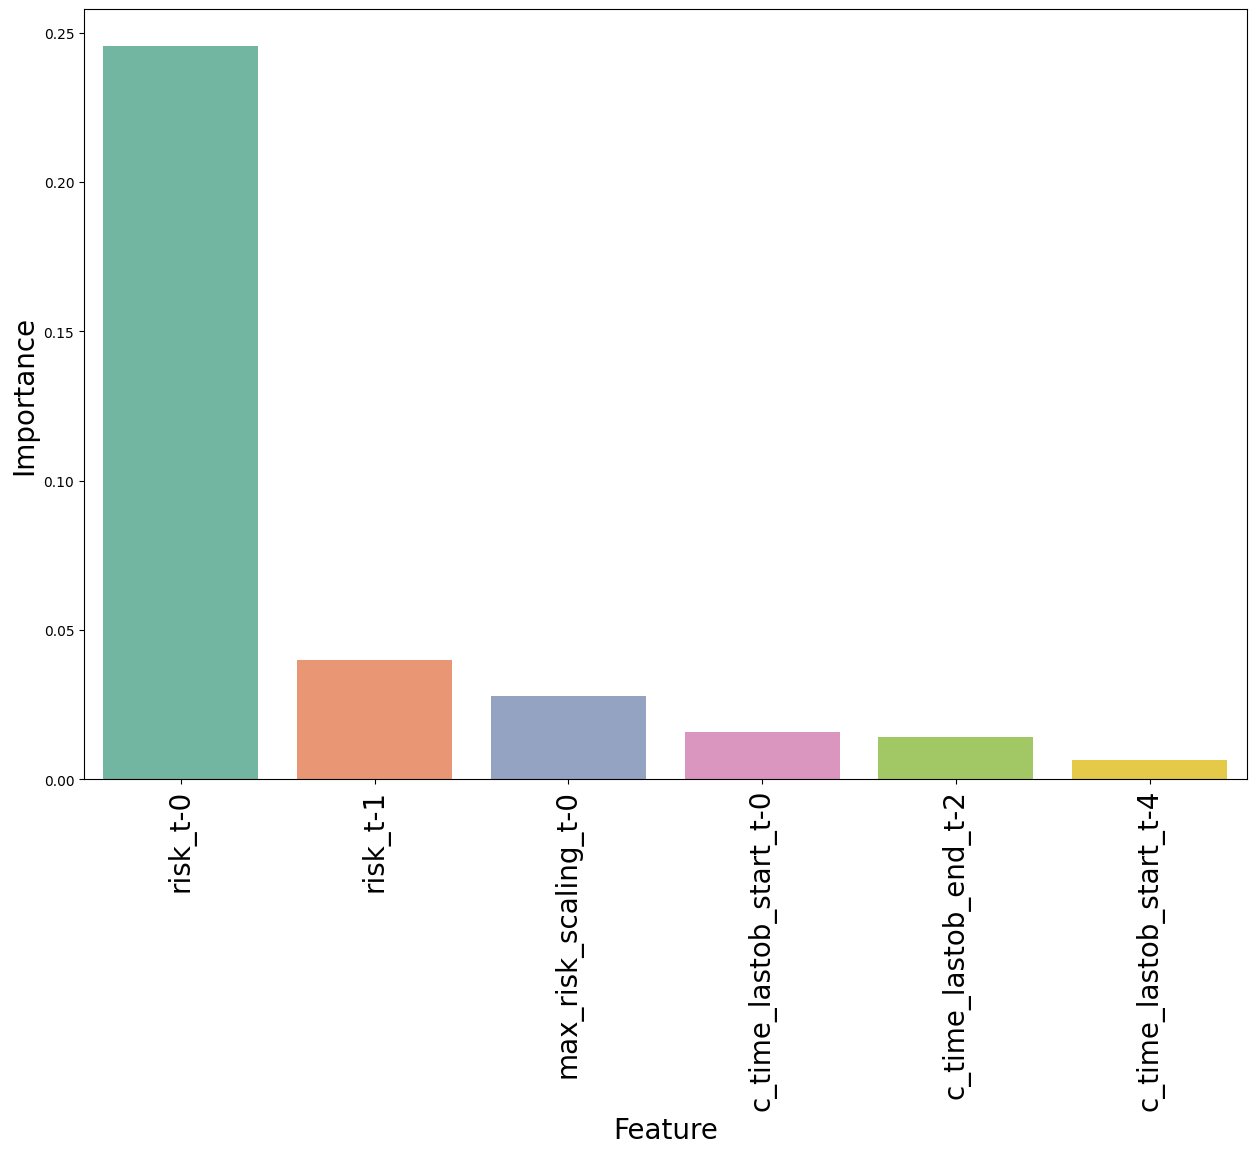

In [18]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
show_df = 6
show_plot = 6

#Using inbuilt class feature_importances of tree based classifiers
model.fit(X,y)

#Creating dataset of feature importances for better visualization
dfimportance = pd.DataFrame(model.feature_importances_)
dfcolumns = pd.DataFrame(X.columns)
feat_importances = pd.concat([dfcolumns,dfimportance],axis=1)
feat_importances.columns = ['Feature','Importance']

#Displaying it
df_sort = feat_importances.sort_values("Importance",ascending=False)
display(df_sort.head(show_df))

plt.figure(figsize=(15,10))
ax = sns.barplot(x='Feature', y='Importance', data=df_sort.iloc[:show_plot], palette="Set2")
ax.set_xticklabels(df_sort['Feature'],rotation=90, fontsize=20)
ax.set_xlabel('Feature',fontsize=20)
ax.set_ylabel('Importance',fontsize=20)
plt.show

In [19]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge

model = Ridge()
max_features = 3 

embeded_lr_selector = SelectFromModel(model,
                                      max_features=max_features)
embeded_lr_selector.fit(X, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
for feature in embeded_lr_feature:
    print(feature)

t_j2k_inc_t-1
t_span_t-1
c_sigma_rdot_t-1
